In [1]:
import os
import rasterio

data_folder = "./prospace_assignment/prospace_assignment"

def calculate_average_shape(folder_path, batch_size=500):
    total_rows = 0
    total_cols = 0
    num_images = 0
    for idx, file_name in enumerate(os.listdir(folder_path), start=1):
        if file_name.endswith('.tif'):
            file_path = os.path.join(folder_path, file_name)
            with rasterio.open(file_path) as src:
                total_rows += src.height
                total_cols += src.width
                num_images += 1
            if idx % batch_size == 0:
                average_rows = total_rows // num_images
                average_cols = total_cols // num_images
                print("Average shape after processing {} images: ({}, {})".format(idx, average_rows, average_cols))
   
    average_rows = total_rows // num_images
    average_cols = total_cols // num_images
    print("Final average shape of the raster images: ({}, {})".format(average_rows, average_cols))
    return (average_rows, average_cols)

average_shape = calculate_average_shape(data_folder)


Average shape after processing 500 images: (29, 30)
Average shape after processing 1000 images: (27, 29)
Average shape after processing 1500 images: (27, 29)
Average shape after processing 2000 images: (28, 31)
Average shape after processing 2500 images: (27, 31)
Average shape after processing 3000 images: (28, 32)
Average shape after processing 3500 images: (27, 31)
Average shape after processing 4000 images: (28, 32)
Average shape after processing 4500 images: (28, 32)
Average shape after processing 5000 images: (30, 34)
Average shape after processing 5500 images: (30, 35)
Average shape after processing 6000 images: (31, 35)
Average shape after processing 6500 images: (32, 36)
Final average shape of the raster images: (32, 36)


In [2]:
import cv2
import csv
import numpy as np

def classify_image(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    green_lower = np.array([36, 25, 25])  
    green_upper = np.array([86, 255, 255]) 
    brown_lower = np.array([10, 50, 20]) 
    brown_upper = np.array([30, 255, 200]) 
    white_lower = np.array([0, 0, 150])
    white_upper = np.array([180, 25, 255])  
  
    green_mask = cv2.inRange(hsv_image, green_lower, green_upper)
    brown_mask = cv2.inRange(hsv_image, brown_lower, brown_upper)
    white_mask = cv2.inRange(hsv_image, white_lower, white_upper)
   
    green_pixels = cv2.countNonZero(green_mask)
    brown_pixels = cv2.countNonZero(brown_mask)
    white_pixels = cv2.countNonZero(white_mask)
    
    if green_pixels > brown_pixels and green_pixels > white_pixels:
        return 'lush'
    elif brown_pixels > green_pixels and brown_pixels > white_pixels:
        return 'growing'
    else:
        return 'no_crop'


annotations = []


def annotate_images(folder_path):
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tif'):
            file_path = os.path.join(folder_path, file_name)
            image = cv2.imread(file_path)
            category = classify_image(image)
            annotations.append((file_path, category))

annotate_images(data_folder)

annotations_file = "annotations.csv"

with open(annotations_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['file_path', 'label'])  
    writer.writerows(annotations)

print("Annotations saved to:", annotations_file)


Annotations saved to: annotations.csv


In [3]:
import pandas as pd

annotations_file = "annotations.csv"

annotations_df = pd.read_csv(annotations_file)

print("Annotations DataFrame:")
print(annotations_df.head())

label_counts = annotations_df['label'].value_counts()

print("\nDistribution of Labels:")
print(label_counts)


Annotations DataFrame:
                                           file_path    label
0  ./prospace_assignment/prospace_assignment\100_...  growing
1  ./prospace_assignment/prospace_assignment\100_...  growing
2  ./prospace_assignment/prospace_assignment\100_...  growing
3  ./prospace_assignment/prospace_assignment\100_...  growing
4  ./prospace_assignment/prospace_assignment\100_...  growing

Distribution of Labels:
label
growing    5474
lush       1258
no_crop      84
Name: count, dtype: int64


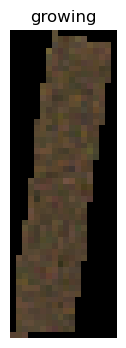

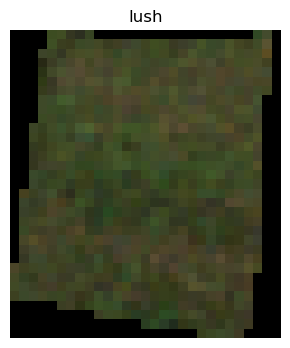

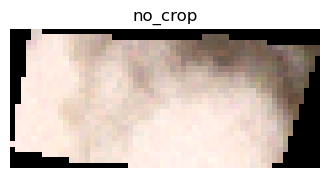

In [4]:
import matplotlib.pyplot as plt

def display_one_image_from_each_category(df):
    unique_labels = df['label'].unique()
    for label in unique_labels:
        image_path = df[df['label'] == label].iloc[3]['file_path']
        image = cv2.imread(image_path)
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(label)
        plt.axis('off')
        plt.show()

display_one_image_from_each_category(annotations_df)


In [5]:
from sklearn.model_selection import train_test_split


def preprocess_image(image_path, target_shape=(32, 36)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_shape)
    image = np.transpose(image, (1, 0, 2))
    image = image.astype(np.float32) / 255.0
    return image

def preprocess_dataset(df, target_shape=(32, 36), test_size=0.2, random_state=42):
    processed_images = np.array([preprocess_image(image_path) for image_path in df['file_path']])
    
    label_to_int = {'no_crop': 0, 'growing': 1, 'lush': 2}
    labels = np.array(df['label'].map(label_to_int))
    X_train, X_test, y_train, y_test = train_test_split(processed_images, labels, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_dataset(annotations_df)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_train:", y_train.shape)
print("Shape of Y_test:", y_test.shape)


unique_labels_train, counts_train = np.unique(y_train, return_counts=True)
unique_labels_test, counts_test = np.unique(y_test, return_counts=True)

print("\nNumber of labels in training set:")
for label, count in zip(unique_labels_train, counts_train):
    print(f"Label: {label}, Count: {count}")

print("\nNumber of labels in testing set:")
for label, count in zip(unique_labels_test, counts_test):
    print(f"Label: {label}, Count: {count}")

Shape of X_train: (5452, 32, 36, 3)
Shape of X_test: (1364, 32, 36, 3)
Shape of Y_train: (5452,)
Shape of Y_test: (1364,)

Number of labels in training set:
Label: 0, Count: 65
Label: 1, Count: 4352
Label: 2, Count: 1035

Number of labels in testing set:
Label: 0, Count: 19
Label: 1, Count: 1122
Label: 2, Count: 223


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape=(32, 36, 3), num_classes=3):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

cnn_model = create_cnn_model()

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


history = cnn_model.fit(X_train, y_train,
                        epochs=100,
                        batch_size=32,
                        validation_data=(X_test, y_test))


test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)






Epoch 1/100


171/171 [==============================] - 4s 18ms/step - loss: 0.2472 - accuracy: 0.9004 - val_loss: 0.1268 - val_accuracy: 0.9545
Epoch 2/100
171/171 [==============================] - 3s 18ms/step - loss: 0.1222 - accuracy: 0.9534 - val_loss: 0.1027 - val_accuracy: 0.9677
Epoch 3/100
171/171 [==============================] - 3s 18ms/step - loss: 0.0964 - accuracy: 0.9663 - val_loss: 0.0995 - val_accuracy: 0.9670
Epoch 4/100
171/171 [==============================] - 3s 18ms/step - loss: 0.0914 - accuracy: 0.9644 - val_loss: 0.1137 - val_accuracy: 0.9575
Epoch 5/100
171/171 [==============================] - 3s 18ms/step - loss: 0.0895 - accuracy: 0.9675 - val_loss: 0.1115 - val_accuracy: 0.9567
Epoch 6/100
171/171 [==============================] - 3s 16ms/step - loss: 0.0725 - accuracy: 0.9729 - val_loss: 0.0761 - val_accuracy: 0.9714
Epoch 7/100
171/171 [==============================] - 3s 16ms/step - loss: 0.0856 - accuracy: 0.9681 - val_loss: 0.0900 - val_acc

Epoch 49/100
171/171 [==============================] - 3s 17ms/step - loss: 0.0104 - accuracy: 0.9969 - val_loss: 0.2542 - val_accuracy: 0.9509
Epoch 50/100
171/171 [==============================] - 3s 16ms/step - loss: 0.0416 - accuracy: 0.9881 - val_loss: 0.2482 - val_accuracy: 0.9560
Epoch 51/100
171/171 [==============================] - 3s 16ms/step - loss: 0.0353 - accuracy: 0.9897 - val_loss: 0.1262 - val_accuracy: 0.9714
Epoch 52/100
171/171 [==============================] - 3s 18ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 0.1289 - val_accuracy: 0.9736
Epoch 53/100
171/171 [==============================] - 3s 16ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1321 - val_accuracy: 0.9773
Epoch 54/100
171/171 [==============================] - 3s 16ms/step - loss: 0.0080 - accuracy: 0.9971 - val_loss: 0.1595 - val_accuracy: 0.9655
Epoch 55/100
171/171 [==============================] - 3s 16ms/step - loss: 0.0097 - accuracy: 0.9967 - val_loss: 0.1413 - val_ac

In [7]:
model_file = "cnn_model.h5"
cnn_model.save(model_file)
print("Trained model saved to:", model_file)

Trained model saved to: cnn_model.h5


C:\Users\AMIT\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


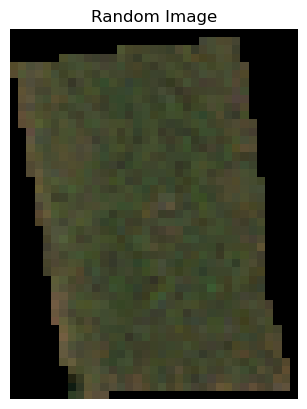

1/1 [==============================] - 0s 26ms/step
Predicted Numeric Label: 2
Predicted Text Label: lush


In [17]:
image_folder = data_folder

def preprocess_image(image_path, target_shape=(32, 36)):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, target_shape)
    processed_image = resized_image.reshape(1, *target_shape, 3) / 255.0
    return processed_image

random_image_name = np.random.choice(os.listdir(image_folder))
random_image_path = os.path.join(image_folder, random_image_name)

random_image = cv2.imread(random_image_path)
plt.imshow(cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB))
plt.title("Random Image")
plt.axis('off')
plt.show()

processed_image = preprocess_image(random_image_path)


predicted_label = cnn_model.predict(processed_image)
predicted_label = tf.argmax(predicted_label, axis=1)

label_to_text = {0: 'no_crop', 1: 'growing', 2: 'lush'}

predicted_text_label = label_to_text[predicted_label.numpy()[0]]

print("Predicted Numeric Label:", predicted_label.numpy()[0])
print("Predicted Text Label:", predicted_text_label)



In [10]:
from sklearn.metrics import classification_report

y_probs = cnn_model.predict(X_test)

y_pred = np.argmax(y_probs, axis=1)

report = classification_report(y_test, y_pred)

print("Classification Report:\n", report)


43/43 [==============================] - 0s 9ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.74      0.72        19
           1       0.98      0.99      0.99      1122
           2       0.96      0.92      0.94       223

    accuracy                           0.98      1364
   macro avg       0.88      0.88      0.88      1364
weighted avg       0.98      0.98      0.98      1364



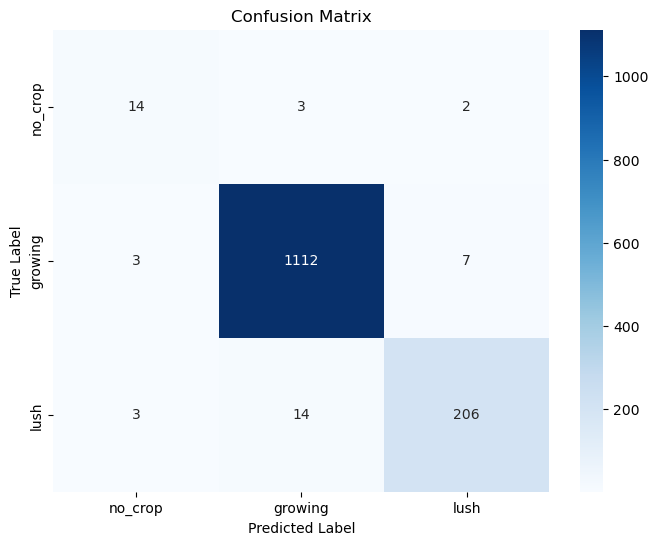

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['no_crop', 'growing', 'lush'], 
            yticklabels=['no_crop', 'growing', 'lush'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
